# IF702 Redes Neurais
Este notebook contém um script base para o projeto da disciplina IF702 Redes Neurais.

In [2]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Leitura e Limpeza dos Dados

A leitura dos dados é feita utilizando a biblioteca `pandas`. O presente exemplo importa a base de dados `mammography`. Caso você esteja trabalhando com outro data set, modifique este trecho de código.
Para importar o conjunto de dados do PAKDD, use a função `pd.read_table` ao invés da `pd.read_csv`.

In [70]:
data_set = pd.read_csv('mammography.csv')
# type(data_set)
# data_set = data_set.drop('class',1)
# data_set

In [71]:
data_set.drop_duplicates(keep=False,inplace=True)  # Remove exemplos repetidos
data_set

,X1,X2,X3,X4,X5,X6,class
0,0.230020,5.072578,-0.276061,0.832444,-0.377866,0.480322,-1
1,0.155491,-0.169390,0.670652,-0.859553,-0.377866,-0.945723,-1
2,-0.784415,-0.443654,5.674705,-0.859553,-0.377866,-0.945723,-1
3,0.546088,0.131415,-0.456387,-0.859553,-0.377866,-0.945723,-1
4,-0.102987,-0.394994,-0.140816,0.979703,-0.377866,1.013566,-1
5,-0.180395,-0.381723,0.264918,0.772950,1.468981,0.852069,-1
6,-0.068603,-0.346334,-0.185897,0.899111,1.743381,1.062319,-1
7,-0.082492,-0.448077,0.896060,-0.859553,-0.377866,-0.945723,-1
8,-0.151600,-0.368452,0.625571,1.197426,-0.377866,1.010519,-1
10,-0.081137,-0.324216,1.031305,1.171687,-0.377866,1.397501,-1


In [72]:
# Imprime as 5 primeiras linhas do data set
data_set.head(5)

,X1,X2,X3,X4,X5,X6,class
0,0.230020,5.072578,-0.276061,0.832444,-0.377866,0.480322,-1
1,0.155491,-0.169390,0.670652,-0.859553,-0.377866,-0.945723,-1
2,-0.784415,-0.443654,5.674705,-0.859553,-0.377866,-0.945723,-1
3,0.546088,0.131415,-0.456387,-0.859553,-0.377866,-0.945723,-1
4,-0.102987,-0.394994,-0.140816,0.979703,-0.377866,1.013566,-1


In [73]:
# Estatísticas sobre as variáveis
data_set.describe()

,X1,X2,X3,X4,X5,X6,class
count,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000
mean,0.333764,0.200042,0.251736,0.365734,0.160780,0.402400,-0.935500
std,1.025813,1.136427,1.101461,0.988616,1.157123,0.939678,0.353348
min,-0.784415,-0.452501,-0.591631,-0.859553,-0.377866,-0.945723,-1.000000
25%,-0.145333,-0.408265,-0.276061,-0.859553,-0.377866,-0.945723,-1.000000
50%,0.111790,-0.271133,-0.005571,0.550163,-0.377866,0.845975,-1.000000
75%,0.508993,0.219887,0.400163,1.027382,0.387549,1.132403,-1.000000
max,31.508443,5.085849,29.477769,9.591164,23.617122,1.949027,1.000000


Agora vamos separar o data set em atributos dependentes (X = features) e independentes (y = classe). No caso do `mammography` a classe majoritária está codificada como -1 e a classe minoritária está codificada como 1. Para treinar nossa rede neural precisamos que os valores de classe sejam 0 e 1 (restrição da biblioteca `keras`), assim modificamos a codificação da majoritária para 0.

Perceba que esse pré-processamento varia de data set para data set.

In [4]:
# Também convertemos os dados para arrays ao invés de DataFrames
X = data_set.iloc[:, :-1].values
y = data_set.iloc[:, -1].values
y = np.where(y == -1, 0, 1)

## Divisão dos Dados em Treino, Validação, e Teste

Aqui dividimos o data set em treino, validação e teste de maneira estratificada.

In [5]:
## Treino: 50%, Validação: 25%, Teste: 25%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/4, 
                                                    random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/3, 
                                                  random_state=42, stratify=y_train)

In [80]:
## Treinamento com divisão dos dados em kfolds
data = data_set.iloc[:,:].values
# data
from sklearn.model_selection import KFold
kfolds = KFold(n_splits=10, shuffle=True)
# kfolds
kfolds.get_n_splits(data)
kfolds

KFold(n_splits=10, random_state=None, shuffle=True)

In [87]:
for train_index, test_index in kfolds.split(data):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print (len(X_test), len(X_train))

785 7060
785 7060
785 7060
785 7060
785 7060
784 7061
784 7061
784 7061
784 7061
784 7061


## Sampling dos Dados e Normalização

Para testar o comportamento da rede com diferentes funções de sampling, as mesmas devem ser implementadas e aplicadas ao conjunto de treinamento antes da normalização dos dados (você também pode investigar qual o efeito de aplicar o sampling após a normalização).

In [7]:
## TO DO -- Implementar as funções de sampling a serem utilizadas

É importante lembrar de normalizar os dados. A classe `StandardScaler` centraliza as variáveis e transforma as features para terem variância unitária. Você pode testar outras opções como o `MinMaxScaler`.

Todas as alternativas estão disponíveis em:
http://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing.

In [6]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

## Definição e Treino da Rede

Aqui definimos a arquitetura da nossa rede neural e treinamos ela.

No presente exemplo a rede possui apenas uma camada escondida. O código é bem intuitivo e a adição de novas camadas pode ser feita através da função `add`.

Para treinar a rede várias funções de otimização estão disponíveis. 

Confira os exemplos em: https://keras.io/optimizers/

O treinamento da rede pode ser interrompido baseado na performance dela em um conjunto de validação através de callbacks.

Confira a documentação da classe `EarlyStopping`: https://keras.io/callbacks/

In [45]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

# Agora adicionamos a primeira camada escondida contendo 16 neurônios e função de ativação
# tangente hiperbólica. Por ser a primeira camada adicionada à rede, precisamos especificar
# a dimensão de entrada (número de features do data set), que no caso do mammography são 6.
classifier.add(Dense(16, activation='relu', input_dim=6))

# classifier.add(Dense(20, activation='relu',))

# classifier.add(Dense(10, activation='relu',))

# classifier.add(Dense(30, activation='relu',))

# classifier.add(Dense(15, activation='relu',))

# classifier.add(Dense(8, activation='relu',))

# Em seguida adicionamos a camada de saída. Como nosso problema é binário só precisamos de
# 1 neurônio com função de ativação sigmoidal. A partir da segunda camada adicionada keras já
# consegue inferir o número de neurônios de entrada (16) e nós não precisamos mais especificar.
classifier.add(Dense(1, activation='relu'))

# Por fim compilamos o modelo especificando um otimizador, a função de custo, e opcionalmente
# métricas para serem observadas durante treinamento.
classifier.compile(optimizer='adam', loss='mean_squared_error')

In [46]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
# Para treinar a rede passamos o conjunto de treinamento e especificamos o tamanho do mini-batch,
# o número máximo de épocas, e opcionalmente callbacks. No presente exemplo utilizamos early
# stopping para interromper o treinamento caso a performance não melhore em um conjunto de validação.
history = classifier.fit(X_train, y_train, batch_size=64, epochs=150, 
                         callbacks=[early_stopping], validation_data=(X_val, y_val))

Train on 3924 samples, validate on 1962 samples
Epoch 1/150
3924/3924 [==============================] - 0s - loss: 0.0355 - val_loss: 0.0320
Epoch 2/150
3924/3924 [==============================] - 0s - loss: 0.0319 - val_loss: 0.0315
Epoch 3/150
3924/3924 [==============================] - 0s - loss: 0.0312 - val_loss: 0.0305
Epoch 4/150
3924/3924 [==============================] - 0s - loss: 0.0296 - val_loss: 0.0272
Epoch 5/150
3924/3924 [==============================] - 0s - loss: 0.0204 - val_loss: 0.0196
Epoch 6/150
3924/3924 [==============================] - 0s - loss: 0.0175 - val_loss: 0.0189
Epoch 7/150
3924/3924 [==============================] - 0s - loss: 0.0176 - val_loss: 0.0186
Epoch 8/150
3924/3924 [==============================] - 0s - loss: 0.0171 - val_loss: 0.0185
Epoch 9/150
3924/3924 [==============================] - 0s - loss: 0.0166 - val_loss: 0.0183
Epoch 10/150
3924/3924 [==============================] - 0s - loss: 0.0163 - val_loss: 0.0182
Epoch 11/15

In [10]:
#utilizado para salvar os pesos da rede
classifier.save_weights("pesos.h5", overwrite=True)

Algumas funções auxiliares.

In [12]:
def extract_final_losses(history):
    """Função para extrair o melhor loss de treino e validação.
    
    Argumento(s):
    history -- Objeto retornado pela função fit do keras.
    
    Retorno:
    Dicionário contendo o melhor loss de treino e de validação baseado 
    no menor loss de validação.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    idx_min_val_loss = np.argmin(val_loss)
    return {'train_loss': train_loss[idx_min_val_loss], 'val_loss': val_loss[idx_min_val_loss]}

def plot_training_error_curves(history):
    """Função para plotar as curvas de erro do treinamento da rede neural.
    
    Argumento(s):
    history -- Objeto retornado pela função fit do keras.
    
    Retorno:
    A função gera o gráfico do treino da rede e retorna None.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Error Curves', xlabel='Epochs', ylabel='Loss (MSE)')
    ax.legend()
    plt.show()

<IPython.core.display.Javascript object>


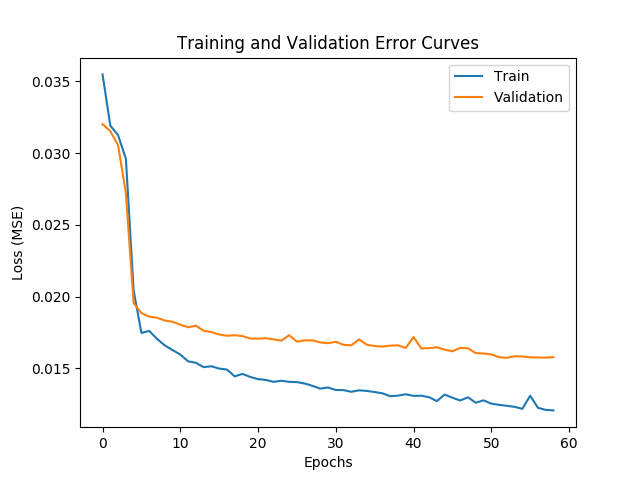

In [47]:
plot_training_error_curves(history)

## Predições no Conjunto de Teste

Agora utilizamos a nossa rede para fazer predições no conjunto de teste e computar métricas de desempenho.

Além das métricas utilizadas aqui, mais métricas de desempenho podem ser encontradas em: http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics

In [18]:
## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

Matriz de confusão
[[1880   19]
 [  36   28]]

Train Loss:       0.0143
Validation Loss:  0.0171
Accuracy:         0.9720
Recall:           0.4375
Precision:        0.5957
F1:               0.5045
AUROC:            0.9044
